# Finite elements for IVBP with Neumann conditions

## Start simple: BVP with Neumann BC

Example 6.10 - Inhomogeneous Neumann BVP

This example is taken from Gockenbach, Sect. 6.5.

In [1]:
from sympy import *
init_printing(use_unicode=True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.linalg import solve_banded

In [3]:
init_session()

IPython console for SymPy 1.10.1 (Python 3.9.12-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.10.1/



In [4]:
u = symbols('u', cls=Function)
l = Symbol('l', real=True, positive=True)
i = Symbol('i', integer=True)
h = Symbol('h', real=True, positive=True)

In [5]:
ode = Eq((-u(x).diff(x, x)),(x-1/2), domain=Interval(0,1))

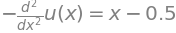

In [6]:
ode

In [7]:
ics = {
    u(x).diff(x).subs(x, 0) : 0,
    u(x).diff(x).subs(x, l) : 0,
    u(0) : 0,
}

In [8]:
srepr(ode)

"Equality(Mul(Integer(-1), Derivative(Function('u')(Symbol('x')), Tuple(Symbol('x'), Integer(2)))), Add(Symbol('x'), Float('-0.5', precision=53)))"

In [9]:
def basis(x, i):
    return np.piecewise(x, [x < (i-1)*h,
                            ((i-1)*h <= x) & (x <= i*h),
                            (i*h < x) & (x <= (i+1)*h),
                            x > (i+1)*h],
                        [0, (x - (i - 1) * h)/h, -(x - (i + 1) * h)/h, 0])

vbasis = np.vectorize(basis)

## Build the piecewise polynomials basis

The following is a single element $\phi_j (x)$ of the basis of piecewise polynomials. This means that, when building the matrixes $\textbf{K}_{ij}$ and $\textbf{M}_{ij}$, one has to take into account to loop on the j index as a function of the i index.

In [10]:
sy_basis = Piecewise(
    (x/h-i+1, (x>(i-1)*h)&(x<i*h)),
    (-x/h+i+1, (x>i*h)&(x<(i+1)*h)),
    (0, True),
); sy_basis

⎧         x                             
⎪-i + 1 + ─  for x > h⋅(i - 1) ∧ x < h⋅i
⎪         h                             
⎪                                       
⎨        x                              
⎪i + 1 - ─   for x > h⋅i ∧ x < h⋅(i + 1)
⎪        h                              
⎪                                       
⎩    0                otherwise         

In [11]:
sy_basis2 = sy_basis**2; sy_basis2

⎧            2                             
⎪⎛         x⎞                              
⎪⎜-i + 1 + ─⎟   for x > h⋅(i - 1) ∧ x < h⋅i
⎪⎝         h⎠                              
⎪                                          
⎨           2                              
⎪⎛        x⎞                               
⎪⎜i + 1 - ─⎟    for x > h⋅i ∧ x < h⋅(i + 1)
⎪⎝        h⎠                               
⎪                                          
⎩      0                 otherwise         

In [12]:
sy_basis2.integrate(x)

⎧                                                                             
⎪                                                                             
⎪                                                                             
⎪                                                                  2   h⋅(i - 
⎪                                               - h⋅(1 - i)⋅(i - 1)  - ───────
⎪                                                                          3  
⎪                                                                             
⎪                                                                             
⎪                                                                             
⎨              2              2                ⎛ 2          ⎞       ⎛ 2       
⎪           h⋅i ⋅(1 - i) - h⋅i ⋅(-i - 1) + h⋅i⋅⎝i  - 2⋅i + 1⎠ - h⋅i⋅⎝i  + 2⋅i 
⎪                                                                             
⎪                                                   

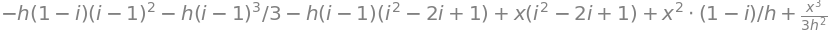

In [13]:
sy_basis2.integrate(x).args[1][0]

In [14]:
sy_dbasis = Derivative(sy_basis, x).doit(); sy_dbasis

⎧ 1                              
⎪ ─   for x > h⋅(i - 1) ∧ x < h⋅i
⎪ h                              
⎪                                
⎨-1                              
⎪───  for x > h⋅i ∧ x < h⋅(i + 1)
⎪ h                              
⎪                                
⎩ 0            otherwise         

In [15]:
sy_dbasis2 = sy_dbasis**2; sy_dbasis2

⎧1                                                                            
⎪──  for (x > h⋅i ∨ x > h⋅(i - 1)) ∧ (x > h⋅i ∨ x < h⋅i) ∧ (x > h⋅(i - 1) ∨ x 
⎪ 2                                                                           
⎨h                                                                            
⎪                                                                             
⎪0                                                       otherwise            
⎩                                                                             

                                        
< h⋅(i + 1)) ∧ (x < h⋅i ∨ x < h⋅(i + 1))
                                        
                                        
                                        
                                        
                                        

In [16]:
sy_dbasis2.piecewise_integrate(x)

⎧x                                                                            
⎪──  for (x > h⋅i ∨ x > h⋅(i - 1)) ∧ (x > h⋅i ∨ x < h⋅i) ∧ (x > h⋅(i - 1) ∨ x 
⎪ 2                                                                           
⎨h                                                                            
⎪                                                                             
⎪0                                                       otherwise            
⎩                                                                             

                                        
< h⋅(i + 1)) ∧ (x < h⋅i ∨ x < h⋅(i + 1))
                                        
                                        
                                        
                                        
                                        

### 1st element of the basis

Consider $\phi_j(x_i)$ with j = 1. Then the integer variable i = j. \
Elements $\phi_0$ and $\phi_n$ are to be defined indipendently from the others with i = 1, ... , n-1.

In [17]:
# Take the general definition of the basis and substitute i = 1
e1 = sy_basis.subs(i, 1); e1

⎧  x                       
⎪  ─     for h > x ∧ x > 0 
⎪  h                       
⎪                          
⎨    x                     
⎪2 - ─  for h < x ∧ x < 2⋅h
⎪    h                     
⎪                          
⎩  0         otherwise     

In [18]:
de1_2 = sy_dbasis2.subs(i,1); de1_2

⎧1                                                                            
⎪──  for (h > x ∨ h < x) ∧ (h > x ∨ x < 2⋅h) ∧ (x > 0 ∨ h < x) ∧ (x > 0 ∨ x < 
⎪ 2                                                                           
⎨h                                                                            
⎪                                                                             
⎪0                                     otherwise                              
⎩                                                                             

    
2⋅h)
    
    
    
    
    

In [19]:
de1_2.integrate((x, 0, 2*h))

And this, my man, is the entry 11 of the stiffness matrix. Time to make this object-oriented and cycle over the indexes.

### Construction of the entries of the K matrix

In [20]:
# Build the main diagonal first
for n in [m+1 for m in range(10)]:
    dummy = sy_dbasis2.subs(i,n).integrate((x, (n-1)*h, (n+1)*h))
    print(dummy)

2/h
2/h
2/h
2/h
2/h
2/h
2/h
2/h
2/h
2/h


In [21]:
e0 = Piecewise(
    (-x/h+i+1, (x>0)&(x<h)),
    (0, True),
); e0

⎧        x                   
⎪i + 1 - ─  for h > x ∧ x > 0
⎨        h                   
⎪                            
⎩    0          otherwise    

### Last try to see if I can implement some sort of inner product

**Note: the following is just for trying and is not related to the computation of matrix K: in fact, it uses the elements of the basis and not their derivatives.**

In [22]:
# Build the second element of the basis
e2 = sy_basis.subs(i, 2); e2

⎧     x                       
⎪-1 + ─   for h < x ∧ x < 2⋅h 
⎪     h                       
⎪                             
⎨    x                        
⎪3 - ─   for x > 2⋅h ∧ x < 3⋅h
⎪    h                        
⎪                             
⎩  0           otherwise      

**WARNING** \ The result below is by no means correct: this may be due to the order of the 

In [23]:
# Compute the product of e1 and e2
e1e2 = e1*e2; e1e2
e1e2.evalf()

⎛⎧   x                        ⎞ ⎛⎧       x                       ⎞
⎜⎪   ─      for h > x ∧ x > 0 ⎟ ⎜⎪-1.0 + ─   for h < x ∧ x < 2⋅h ⎟
⎜⎪   h                        ⎟ ⎜⎪       h                       ⎟
⎜⎪                            ⎟ ⎜⎪                               ⎟
⎜⎨      x                     ⎟⋅⎜⎨      x                        ⎟
⎜⎪2.0 - ─  for h < x ∧ x < 2⋅h⎟ ⎜⎪3.0 - ─   for x > 2⋅h ∧ x < 3⋅h⎟
⎜⎪      h                     ⎟ ⎜⎪      h                        ⎟
⎜⎪                            ⎟ ⎜⎪                               ⎟
⎝⎩   0          otherwise     ⎠ ⎝⎩   0            otherwise      ⎠

In [24]:
integrate(e1*e2, (x, 0, 2*h))

In [25]:
type(e1e2)

sympy.core.mul.Mul

## B-spline tries

In [26]:
d = 1 # degree pf the B-splines
knots = tuple(range(10)); len(knots)

In [27]:
bspline_basis(d, knots, 7, x)

⎧x - 7  for x ≥ 7 ∧ x ≤ 8
⎪                        
⎨9 - x  for x ≥ 8 ∧ x ≤ 9
⎪                        
⎩  0        otherwise    

## Implementing matrix representation of piecewise linear polynomials basis

Consider a uniformly spaced grid on the x axis, with n+1 nodes $x_i$, such that $x_0 = 0$ and $x_n = l$. Then consider the piecewise polynomials: every element $\phi_j$ takes some value in every interval, and this value can be viewed as the entry of a vector of n components. \
Ex. $\phi_0 = [-\frac{x}{h}+1, 0, 0, ..., 0]$ \
We can build a matrix whose rows are the vectors that represent the piecewise polynomials in the form that we have showed. With this convention, we have n+1 rows that represent the piecewise polynomials, and n columns, one for every interval.

In [28]:
sy_basis

⎧         x                             
⎪-i + 1 + ─  for x > h⋅(i - 1) ∧ x < h⋅i
⎪         h                             
⎪                                       
⎨        x                              
⎪i + 1 - ─   for x > h⋅i ∧ x < h⋅(i + 1)
⎪        h                              
⎪                                       
⎩    0                otherwise         

In [29]:
# The first (and only) element of the e0 component
# From now on, the elements of the basis are called eX, with X their index,
# eXY are the entries of the matrix built with the vectors eX,
# deXY are the elements of the matrix of the derivatives,
# eXeY are the elements of the matrix that has the scalar products as components

e00 = sy_basis.args[1][0]; e00

In [30]:
enn = sy_basis.args[0][0]; enn

In [31]:
# Fix number of intervals
n = 10

In [32]:
# Build the matrix from scratch: it is a rectangular matrix.
# The matrix can be viewed as a square matrix with "descending" values
# (negative derivative) on the main diagonal, and a single off-diag
# with "ascending" values, below the main diagonal. Then we add the
# n+1 row that only contains the 

eii = np.ones(n+1)*e00; eii

array([1.0*i + 1.0 - 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
       1.0*i + 1.0 - 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
       1.0*i + 1.0 - 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
       1.0*i + 1.0 - 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
       1.0*i + 1.0 - 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
       1.0*i + 1.0 - 1.0*x/h], dtype=object)

In [33]:
eii_1 = np.ones(n)*enn; eii_1

array([-1.0*i + 1.0 + 1.0*x/h, -1.0*i + 1.0 + 1.0*x/h,
       -1.0*i + 1.0 + 1.0*x/h, -1.0*i + 1.0 + 1.0*x/h,
       -1.0*i + 1.0 + 1.0*x/h, -1.0*i + 1.0 + 1.0*x/h,
       -1.0*i + 1.0 + 1.0*x/h, -1.0*i + 1.0 + 1.0*x/h,
       -1.0*i + 1.0 + 1.0*x/h, -1.0*i + 1.0 + 1.0*x/h], dtype=object)

In [34]:
shape(np.diag(eii_1))

In [35]:
shape(np.diag(eii))

In [36]:
# This is ok but from here I cannot access the entries

e = Matrix(np.diag(eii) + np.diag(eii_1, -1)); e

⎡              x                                                              
⎢1.0⋅i + 1.0 - ─          0                 0                 0               
⎢              h                                                              
⎢                                                                             
⎢           1.0⋅x                x                                            
⎢-i + 1.0 + ─────  1.0⋅i + 1.0 - ─          0                 0               
⎢             h                  h                                            
⎢                                                                             
⎢                             1.0⋅x                x                          
⎢       0          -i + 1.0 + ─────  1.0⋅i + 1.0 - ─          0               
⎢                               h                  h                          
⎢                                                                             
⎢                                               1.0⋅

In [37]:
m = np.diag(eii_1, -1) + np.diag(eii); m

array([[1.0*i + 1.0 - 1.0*x/h, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [-1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h, 1.0*i + 1.0 - 1.0*x/h,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h,
        1.0*i + 1.0 - 1.0*x/h, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h,
        1.0*i + 1.0 - 1.0*x/h, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, -1.0*i + 1.0 + 1.0*x/h,
        1.0*i + 1.0 - 1.0*x/h]], dtype=object)

In [38]:
e = zeros(n+1, n); e;

In [39]:
lambdify(args=[x,h,i], expr=e00, modules=["numpy"])

<function _lambdifygenerated(x, h, i)>

In [40]:
i = Symbol("i", integer=True)

In [41]:
n = 10

# We build the matrix of the elements starting from a list of lists:
# each sublist is filled with conditional statements with the
# sympy objects e00 and enn that represent the values of the pp basis'
# elements in a given interval (represented by index j). The index i
# loops on the pp basis (from 0 to n) and is substituted in the expr
# e00 and enn. What we obtain is a pure sympy.Matrix object.

elist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a!=0)&(b==a-1): lista[b]=enn.subs(i, b)
        elif a==b: lista[b]=e00.subs(i, b)
        else: lista[b]=0
    elist.append(lista)
e = Matrix(elist); e

⎡    x                                                                       ⎤
⎢1 - ─    0      0       0       0       0       0       0       0       0   ⎥
⎢    h                                                                       ⎥
⎢                                                                            ⎥
⎢    x      x                                                                ⎥
⎢1 + ─  2 - ─    0       0       0       0       0       0       0       0   ⎥
⎢    h      h                                                                ⎥
⎢                                                                            ⎥
⎢         x        x                                                         ⎥
⎢  0      ─    3 - ─     0       0       0       0       0       0       0   ⎥
⎢         h        h                                                         ⎥
⎢                                                                            ⎥
⎢                   x      x                        

In [42]:
e00.diff(x)

In [43]:
# We build the matrix of the derivatives in the same way as we have built
# the matrix of the elements.

delist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a!=0)&(b==a-1): lista[b]=enn.diff(x)
        elif a==b: lista[b]=e00.diff(x)
        else: lista[b]=0
    delist.append(lista)
de = Matrix(delist); de

⎡-1                                              ⎤
⎢───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h                                              ⎥
⎢                                                ⎥
⎢ 1   -1                                         ⎥
⎢ ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                         ⎥
⎢                                                ⎥
⎢      1   -1                                    ⎥
⎢ 0    ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h                                    ⎥
⎢                                                ⎥
⎢           1   -1                               ⎥
⎢ 0    0    ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h                               ⎥
⎢                                                ⎥
⎢                1   -1                          ⎥
⎢ 0    0    0    ─   ───   0    0    0    0    0 ⎥
⎢                h    h                          ⎥
⎢                              

In [44]:
# Checking that the shape is the one that we want

shape(de)

In [45]:
# And now try to implement the damn scalar product as a matrix product
# of the de matrix and de.T. The resulting matrix is the matrix of the
# integrands of the matrix Kij, and we should call it Iij

Iij = de*de.T; Iij

⎡1    -1                                              ⎤
⎢──   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ 2     2                                             ⎥
⎢h     h                                              ⎥
⎢                                                     ⎥
⎢-1   2    -1                                         ⎥
⎢───  ──   ───   0    0    0    0    0    0    0    0 ⎥
⎢  2   2     2                                        ⎥
⎢ h   h     h                                         ⎥
⎢                                                     ⎥
⎢     -1   2    -1                                    ⎥
⎢ 0   ───  ──   ───   0    0    0    0    0    0    0 ⎥
⎢       2   2     2                                   ⎥
⎢      h   h     h                                    ⎥
⎢                                                     ⎥
⎢          -1   2    -1                               ⎥
⎢ 0    0   ───  ──   ───   0    0    0    0    0    0 ⎥
⎢            2   2     2                        

In [46]:
# Access elements

Iij.row(0)[0]

In [47]:
Iij.row(0)[0].integrate((x, 0, h))

In [48]:
# Try function min(x,y)

a, b = 1, 2
min(a,b)

In [49]:
len(Iij.row(0))

In [50]:
klist = []
for a in range(len(Iij.col(0))):
    lista = [0 for b in range(len(Iij.row(0)))]
    for b,_ in enumerate(lista):
        lista[b] = Iij.row(a)[b].integrate((x, min(a,b)*h, (min(a,b)+1)*h))
    klist.append(lista)

Kij = Matrix(klist); Kij

⎡ 1   -1                                              ⎤
⎢ ─   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                              ⎥
⎢                                                     ⎥
⎢-1    2   -1                                         ⎥
⎢───   ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h    h                                         ⎥
⎢                                                     ⎥
⎢     -1    2   -1                                    ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h    h                                    ⎥
⎢                                                     ⎥
⎢          -1    2   -1                               ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h    h                               ⎥
⎢                                                     ⎥
⎢               -1    2   -1                          ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0    0

## Implementing vector representation of rhs function

In [55]:
# The rhs function may be defined as a sympy object

rhs = x - 1/2; rhs

In [78]:
rhsi = Matrix([rhs for i in range(n)]); rhsi

⎡x - 0.5⎤
⎢       ⎥
⎢x - 0.5⎥
⎢       ⎥
⎢x - 0.5⎥
⎢       ⎥
⎢x - 0.5⎥
⎢       ⎥
⎢x - 0.5⎥
⎢       ⎥
⎢x - 0.5⎥
⎢       ⎥
⎢x - 0.5⎥
⎢       ⎥
⎢x - 0.5⎥
⎢       ⎥
⎢x - 0.5⎥
⎢       ⎥
⎣x - 0.5⎦

In [89]:
rhslist = []
for row in range(len(e.col(0))):
    rhslist.append((e.row(row)*rhsi).integrate((x, (row)*h, (row+1)*h)))

Matrix(rhslist)

⎡                     2                              ⎤
⎢- 0.333333333333333⋅h  + 0.5⋅h⋅(1.0⋅h + 0.5) - 0.5⋅h⎥
⎢                                                    ⎥
⎢                        2                           ⎥
⎢                   4.5⋅h  - 1.5⋅h                   ⎥
⎢                                                    ⎥
⎢                        2                           ⎥
⎢                   7.5⋅h  - 1.5⋅h                   ⎥
⎢                                                    ⎥
⎢                        2                           ⎥
⎢                  10.5⋅h  - 1.5⋅h                   ⎥
⎢                                                    ⎥
⎢                        2                           ⎥
⎢                  13.5⋅h  - 1.5⋅h                   ⎥
⎢                                                    ⎥
⎢                        2                           ⎥
⎢                  16.5⋅h  - 1.5⋅h                   ⎥
⎢                                                    ⎥
⎢         

In [85]:
Integral(Matrix(elist).row(0)*rhsi, (x, 0, h)).doit()

⎡                     2                              ⎤
⎣- 0.333333333333333⋅h  + 0.5⋅h⋅(1.0⋅h + 0.5) - 0.5⋅h⎦

In [69]:
((Matrix(elist).T*rhsi).row(0)[0]).integrate((x, 0, h))